In [ ]:
# Install necessary libraries if not already present
# !pip install torch torchvision numpy kagglehub scikit-learn

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import numpy as np
import os
import shutil
import glob
import kagglehub
from sklearn.model_selection import train_test_split
from typing import List, Tuple

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define global constants and hyperparameters
# Binary Classification: sleepy vs non-sleepy
CLASS_NAMES = ["non-sleepy", "sleepy"]
NUM_CLASSES = len(CLASS_NAMES)  # 2 classes
BATCH_SIZE = 32
LEARNING_RATE = 1e-4
NUM_EPOCHS = 10
IMAGE_SIZE = 224 # Standard size for most CNN/Transformer models

# Original emotion names for reference (used to map to binary)
ORIGINAL_CLASS_NAMES = [
    "anger", "contempt", "disgust", "fear",
    "happy", "neutral", "sad", "surprise",
    "sleepy"
]

Using device: cuda


In [ ]:
# --- 1. Download Dataset from Kaggle Hub ---
KAGGLE_DATASET = "aklimarimi/8-facial-expressions-for-yolo"
print(f"Downloading dataset: {KAGGLE_DATASET}...")

download_path = kagglehub.dataset_download(KAGGLE_DATASET)
print(f"Path to downloaded files: {download_path}")

# --- 2. Extract and Prepare Data Structure ---
YOLO_ROOT = "facial_expression_data"
RESTRUCTURED_DIR = "fer_classification_data"

if not os.path.exists(YOLO_ROOT):
    os.makedirs(YOLO_ROOT)

# Move contents from the download path to the expected
if os.path.isdir(download_path):
    print("Copying contents from download_path to YOLO_ROOT...")

    # Identify the top-level directory containing the YOLO structure (e.g., '9 Facial Expressions...')
    content_dirs = [d for d in os.listdir(download_path) if os.path.isdir(os.path.join(download_path, d))]

    if content_dirs:
        source_path = os.path.join(download_path, content_dirs[0])

        # Iterate over contents of the source folder (train, valid, test, data.yaml)
        for item in os.listdir(source_path):
            s = os.path.join(source_path, item)
            d = os.path.join(YOLO_ROOT, item)

            # Use shutil.copytree for directories and shutil.copy2 for files
            if os.path.isdir(s):
                if os.path.exists(d):
                    shutil.rmtree(d) # Clean up previous attempts
                shutil.copytree(s, d)
            elif os.path.isfile(s):
                shutil.copy2(s, d) # Use copy2 to preserve metadata

    print(f"Data successfully copied to YOLO format at: {YOLO_ROOT}")

# --- 3. Custom Restructuring Function (YOLO -> Binary Classification) ---
def restructure_yolo_to_binary_classification(yolo_root, output_root, original_class_names):
    """
    Parses YOLO-style dataset and creates binary classification structure:
    - 'sleepy': original class_id 8 (sleepy)
    - 'non-sleepy': all other classes (0-7)
    """
    if os.path.exists(output_root):
        print(f"Clearing existing output directory: {output_root}")
        shutil.rmtree(output_root)

    splits = [d for d in os.listdir(yolo_root) if os.path.isdir(os.path.join(yolo_root, d)) and d in ['train', 'valid', 'test']]

    if not splits:
         print(f"Error: Could not find 'train', 'valid', or 'test' subfolders in {yolo_root}")
         return None

    print(f"Found splits: {splits}. Starting binary restructuring...")

    # Find the index of 'sleepy' class (should be 8 in the original list)
    sleepy_class_id = original_class_names.index("sleepy")
    print(f"Sleepy class ID: {sleepy_class_id}")

    for split in splits:
        split_images_dir = os.path.join(yolo_root, split, 'images')
        split_labels_dir = os.path.join(yolo_root, split, 'labels')

        if not os.path.isdir(split_images_dir) or not os.path.isdir(split_labels_dir):
            print(f"Skipping {split}: images or labels directory not found in the expected path.")
            continue

        output_split_dir = os.path.join(output_root, split)

        # Create only two class folders
        os.makedirs(os.path.join(output_split_dir, "non-sleepy"), exist_ok=True)
        os.makedirs(os.path.join(output_split_dir, "sleepy"), exist_ok=True)

        label_files = glob.glob(os.path.join(split_labels_dir, '*.txt'))

        for label_path in label_files:
            try:
                with open(label_path, 'r') as f:
                    first_line = f.readline().strip()
                    if not first_line: continue

                    # YOLO format: [class_id center_x center_y width height]
                    class_id = int(first_line.split()[0])

                    # Guard against class IDs outside the defined range
                    if class_id >= len(original_class_names):
                        print(f"Warning: Class ID {class_id} out of range. Skipping image.")
                        continue

                    # Binary classification: sleepy vs non-sleepy
                    if class_id == sleepy_class_id:
                        binary_class_name = "sleepy"
                    else:
                        binary_class_name = "non-sleepy"

                    # Find and copy the image
                    label_filename = os.path.basename(label_path)

                    # Try common image extensions (.jpg, then .png)
                    image_filename_base = label_filename.replace('.txt', '')

                    image_path_src = os.path.join(split_images_dir, image_filename_base + '.jpg')
                    if not os.path.exists(image_path_src):
                        image_path_src = os.path.join(split_images_dir, image_filename_base + '.png')

                    if os.path.exists(image_path_src):
                        target_dir = os.path.join(output_split_dir, binary_class_name)
                        shutil.copy(image_path_src, target_dir)

            except Exception as e:
                print(f"Error processing {label_path}: {e}")

    print("Binary restructuring complete.")
    return output_root

# RUN RESTRUCTURING
IMAGE_ROOT = restructure_yolo_to_binary_classification(YOLO_ROOT, RESTRUCTURED_DIR, ORIGINAL_CLASS_NAMES)


# --- 4. Define Data Transforms and Loaders ---

# Standard transforms for pre-trained CNN/Transformer models
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # ImageNet mean/std
    ]),
    'val': transforms.Compose([
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Create DataLoaders using the restructured directories
try:
    train_dir = os.path.join(IMAGE_ROOT, 'train')
    val_dir = os.path.join(IMAGE_ROOT, 'valid')

    # Use ImageFolder on the newly created classification structure
    train_dataset = datasets.ImageFolder(train_dir, data_transforms['train'])
    val_dataset = datasets.ImageFolder(val_dir, data_transforms['val'])

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

    dataloaders = {'train': train_loader, 'val': val_loader}
    dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset)}
    class_names = train_dataset.classes # Get actual classes found by ImageFolder

    print(f"\nSuccessfully loaded data into ImageFolder structure.")
    print(f"Total training images: {dataset_sizes['train']}")
    print(f"Total validation images: {dataset_sizes['val']}")
    print(f"Classes (verified by ImageFolder): {class_names}")

except Exception as e:
    print(f"\n--- DATA LOADING ERROR ---")
    print(f"An error occurred after restructuring. Please verify the contents of {IMAGE_ROOT}.")
    raise e

100%|██████████| 3.77G/3.77G [02:52<00:00, 23.4MB/s]

Extracting files...


Path to downloaded files: /root/.cache/kagglehub/datasets/aklimarimi/8-facial-expressions-for-yolo/versions/4
Copying contents from download_path to YOLO_ROOT...
Data successfully copied to YOLO format at: facial_expression_data
Found splits: ['train', 'valid', 'test']. Starting binary restructuring...
Sleepy class ID: 8
Binary restructuring complete.

Successfully loaded data into ImageFolder structure.
Total training images: 64864
Total validation images: 1720
Classes (verified by ImageFolder): ['non-sleepy', 'sleepy']


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
import torch
import torch.nn as nn

# --- 1. Define Key Components (Swin and ResNet parts) ---

class SwinBlock(nn.Module):
    """Conceptual Swin Transformer Block placeholder."""
    def __init__(self, in_features, dim):
        super().__init__()
        self.norm = nn.LayerNorm(in_features)
        self.mlp = nn.Sequential(
            nn.Linear(in_features, dim),
            nn.GELU(),
            nn.Linear(dim, in_features)
        )
    def forward(self, x):
        x = self.norm(x)
        x = x + self.mlp(x)
        return x

class SEResNetBlock(nn.Module):
    """
    A Residual Block with Squeeze-and-Excitation (SE) Attention.
    Fixed to handle channel changes (projection shortcut).
    """
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()

        # Main Path
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels)
        )

        # Squeeze-and-Excitation (SE) Block
        ratio = 16
        self.se_block = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(out_channels, out_channels // ratio, kernel_size=1),
            nn.ReLU(),
            nn.Conv2d(out_channels // ratio, out_channels, kernel_size=1),
            nn.Sigmoid()
        )

        self.relu = nn.ReLU(inplace=True)

        # Shortcut Path (Projection)
        # If input and output channels differ, or stride > 1, we must project 'identity' to match.
        self.downsample = None
        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = x

        # Main path
        out = self.conv(x)

        # Apply SE Attention
        scale = self.se_block(out)
        out = out * scale

        # Project identity if shapes don't match
        if self.downsample is not None:
            identity = self.downsample(x)

        # Residual connection
        out += identity
        return self.relu(out)

# --- 2. Define the Hybrid Model (FIXED with Pooling) ---

class SwinSEResNetHybrid(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()

        # 1. CNN (SE-ResNet) Backbone
        self.cnn_backbone = nn.Sequential(
            # Initial Convolution
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),

            # Residual Blocks
            SEResNetBlock(64, 64),
            SEResNetBlock(64, 128, stride=2)
        )

        # *** CRITICAL FIX: Global Average Pooling ***
        # Reduces [Batch, 128, 28, 28] -> [Batch, 128, 1, 1] to save memory
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))

        # 2. Dynamic Feature Size Calculation
        with torch.no_grad():
            dummy_input = torch.zeros(1, 3, 224, 224)
            cnn_out = self.cnn_backbone(dummy_input)
            pooled_out = self.global_pool(cnn_out)
            self.flattened_size = pooled_out.numel() # Should be 128
            self.swin_dim = self.flattened_size

        # 3. Transformer (Swin) Part
        self.swin_stage = SwinBlock(in_features=self.swin_dim, dim=self.swin_dim * 4)

        # 4. Classification Head (Binary Classification)
        self.classifier = nn.Sequential(
            nn.Linear(self.swin_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)  # 2 classes: non-sleepy, sleepy
        )

    def forward(self, x):
        # 1. CNN Feature Extraction
        cnn_features = self.cnn_backbone(x)

        # 2. Global Pooling
        pooled_features = self.global_pool(cnn_features)

        # 3. Flatten for Transformer
        flat_features = pooled_features.view(pooled_features.size(0), -1)

        # 4. Transformer Stage
        fused_features = self.swin_stage(flat_features)

        # 5. Classification
        output = self.classifier(fused_features)
        return output

# Instantiate the model for Binary Classification
model = SwinSEResNetHybrid(num_classes=2)
model = model.to(device)

print(f"Model instantiated successfully for BINARY classification.")
print(f"Classes: {CLASS_NAMES}")
print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

Model instantiated successfully for BINARY classification.
Classes: ['non-sleepy', 'sleepy']
Trainable parameters: 481,934


In [ ]:
# --- Define Loss and Optimizer ---
criterion = nn.CrossEntropyLoss()
# AdamW is often preferred for models involving Transformer blocks
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)
# Learning Rate Scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# --- Training Function ---
def train_model(model, criterion, optimizer, scheduler, num_epochs=NUM_EPOCHS):
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                # Forward pass
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Deep copy the model if it's the best performing so far
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                # Save only the state dictionary
                torch.save(model.state_dict(), 'best_model_weights.pth')
                print(f'Validation accuracy improved to {best_acc:.4f}. Saving model weights.')

    print(f'Training complete. Best val Acc: {best_acc:.4f}')

    # Load best model weights
    try:
        model.load_state_dict(torch.load('best_model_weights.pth'))
    except FileNotFoundError:
        print("Warning: Best model weights file not found. Skipping loading.")

    return model


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def train_model(model, criterion, optimizer, scheduler, num_epochs=NUM_EPOCHS):
    best_acc = 0.0
    # Dictionary to store history for plotting later
    history = {
        'train_loss': [], 'val_loss': [],
        'train_acc': [], 'val_acc': [],
        'precision': [], 'recall': [], 'f1': []
    }

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0
            all_preds = []
            all_labels = []

            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

                # Collect for metrics
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            # Calculate Advanced Metrics during Validation
            if phase == 'val':
                # 'macro' average gives equal weight to each class
                prec = precision_score(all_labels, all_preds, average='macro', zero_division=0)
                rec = recall_score(all_labels, all_preds, average='macro', zero_division=0)
                f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)

                history['precision'].append(prec)
                history['recall'].append(rec)
                history['f1'].append(f1)
                history['val_loss'].append(epoch_loss)
                history['val_acc'].append(epoch_acc.item())

                print(f'val Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} P: {prec:.4f} R: {rec:.4f} F1: {f1:.4f}')
            else:
                history['train_loss'].append(epoch_loss)
                history['train_acc'].append(epoch_acc.item())
                print(f'train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                torch.save(model.state_dict(), 'best_model_weights.pth')

    return model, history, all_preds, all_labels

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_training_metrics(history):
    """Plot training metrics: Loss, Accuracy, Precision, Recall, F1-Score"""
    fig, axs = plt.subplots(2, 3, figsize=(18, 10))

    # Loss plots
    axs[0, 0].plot(history['train_loss'], marker='o', label='Train Loss', color='blue')
    axs[0, 0].plot(history['val_loss'], marker='s', label='Val Loss', color='red')
    axs[0, 0].set_title('Loss over Epochs')
    axs[0, 0].set_xlabel('Epoch')
    axs[0, 0].set_ylabel('Loss')
    axs[0, 0].legend()
    axs[0, 0].grid(True, linestyle='--', alpha=0.6)

    # Accuracy plots
    axs[0, 1].plot(history['train_acc'], marker='o', label='Train Acc', color='blue')
    axs[0, 1].plot(history['val_acc'], marker='s', label='Val Acc', color='red')
    axs[0, 1].set_title('Accuracy over Epochs')
    axs[0, 1].set_xlabel('Epoch')
    axs[0, 1].set_ylabel('Accuracy')
    axs[0, 1].legend()
    axs[0, 1].grid(True, linestyle='--', alpha=0.6)

    # Precision
    axs[0, 2].plot(history['precision'], marker='o', label='Precision', color='green')
    axs[0, 2].set_title('Precision over Epochs')
    axs[0, 2].set_xlabel('Epoch')
    axs[0, 2].set_ylabel('Precision')
    axs[0, 2].legend()
    axs[0, 2].grid(True, linestyle='--', alpha=0.6)

    # Recall
    axs[1, 0].plot(history['recall'], marker='o', label='Recall', color='orange')
    axs[1, 0].set_title('Recall over Epochs')
    axs[1, 0].set_xlabel('Epoch')
    axs[1, 0].set_ylabel('Recall')
    axs[1, 0].legend()
    axs[1, 0].grid(True, linestyle='--', alpha=0.6)

    # F1-Score
    axs[1, 1].plot(history['f1'], marker='o', label='F1-Score', color='purple')
    axs[1, 1].set_title('F1-Score over Epochs')
    axs[1, 1].set_xlabel('Epoch')
    axs[1, 1].set_ylabel('F1-Score')
    axs[1, 1].legend()
    axs[1, 1].grid(True, linestyle='--', alpha=0.6)

    # Combined metrics
    axs[1, 2].plot(history['precision'], marker='o', label='Precision', color='green')
    axs[1, 2].plot(history['recall'], marker='s', label='Recall', color='orange')
    axs[1, 2].plot(history['f1'], marker='^', label='F1-Score', color='purple')
    axs[1, 2].set_title('All Metrics Comparison')
    axs[1, 2].set_xlabel('Epoch')
    axs[1, 2].set_ylabel('Score')
    axs[1, 2].legend()
    axs[1, 2].grid(True, linestyle='--', alpha=0.6)

    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(y_true, y_pred, class_names=['non-sleepy', 'sleepy']):
    """Plot confusion matrix with detailed metrics"""
    cm = confusion_matrix(y_true, y_pred)

    # Calculate metrics from confusion matrix
    tn, fp, fn, tp = cm.ravel()

    # Calculate additional metrics
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # Plot 1: Confusion Matrix Heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1,
                xticklabels=class_names, yticklabels=class_names, cbar_kws={'label': 'Count'})
    ax1.set_xlabel('Predicted Label', fontsize=12)
    ax1.set_ylabel('True Label', fontsize=12)
    ax1.set_title('Confusion Matrix', fontsize=14, fontweight='bold')

    # Add counts to the heatmap
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            text = ax1.text(j, i, cm[i, j], ha="center", va="center", color="black", fontsize=14)

    # Plot 2: Metrics Summary
    metrics_summary = {
        'True Positive (TP)': tp,
        'True Negative (TN)': tn,
        'False Positive (FP)': fp,
        'False Negative (FN)': fn,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall (Sensitivity)': recall,
        'Specificity': specificity,
        'F1-Score': f1
    }

    ax2.axis('off')
    ax2.set_title('Classification Metrics', fontsize=14, fontweight='bold')

    # Create table
    table_data = []
    for key, value in metrics_summary.items():
        if 'TP' in key or 'TN' in key or 'FP' in key or 'FN' in key:
            table_data.append([key, f'{value:,}'])
        else:
            table_data.append([key, f'{value:.4f}'])

    table = ax2.table(cellText=table_data, cellLoc='left', loc='center',
                     colWidths=[0.6, 0.4])
    table.auto_set_font_size(False)
    table.set_fontsize(11)
    table.scale(1, 2)

    # Style the header
    for i in range(2):
        table[(0, i)].set_facecolor('#4CAF50')
        table[(0, i)].set_text_props(weight='bold', color='white')

    plt.tight_layout()
    plt.show()

def plot_custom_metrics(history, y_true=None, y_pred=None):
    """Main plotting function - calls all visualization functions"""
    # Plot training metrics
    plot_training_metrics(history)

    # Plot confusion matrix if predictions are provided
    if y_true is not None and y_pred is not None:
        plot_confusion_matrix(y_true, y_pred, class_names=['non-sleepy', 'sleepy'])

# Usage example:
# trained_model, history, all_preds, all_labels = train_model(model, criterion, optimizer, scheduler)
# plot_custom_metrics(history, all_labels, all_preds)

Epoch 1/10
----------


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


train Loss: 0.3619 Acc: 0.8720
val Loss: 0.3471 Acc: 0.8721 P: 0.8244 R: 0.5945 F1: 0.6231
Epoch 2/10
----------


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


train Loss: 0.3277 Acc: 0.8848
val Loss: 0.3048 Acc: 0.8942 P: 0.8500 R: 0.6848 F1: 0.7308
Epoch 3/10
----------


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


train Loss: 0.2983 Acc: 0.8965
val Loss: 0.2765 Acc: 0.9041 P: 0.8883 R: 0.7035 F1: 0.7554
Epoch 4/10
----------


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


train Loss: 0.2806 Acc: 0.9019
val Loss: 0.2783 Acc: 0.9029 P: 0.8813 R: 0.7028 F1: 0.7535
Epoch 5/10
----------


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


train Loss: 0.2654 Acc: 0.9062
val Loss: 0.2619 Acc: 0.9099 P: 0.9102 R: 0.7150 F1: 0.7702
Epoch 6/10
----------


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


train Loss: 0.2415 Acc: 0.9117
val Loss: 0.2392 Acc: 0.9105 P: 0.9021 R: 0.7218 F1: 0.7753
Epoch 7/10
----------


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


train Loss: 0.2350 Acc: 0.9129
val Loss: 0.2343 Acc: 0.9128 P: 0.9076 R: 0.7280 F1: 0.7821
Epoch 8/10
----------


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


train Loss: 0.2323 Acc: 0.9141
val Loss: 0.2307 Acc: 0.9140 P: 0.9062 R: 0.7335 F1: 0.7869
Epoch 9/10
----------


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


train Loss: 0.2280 Acc: 0.9150
val Loss: 0.2326 Acc: 0.9099 P: 0.8739 R: 0.7392 F1: 0.7849
Epoch 10/10
----------


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


train Loss: 0.2267 Acc: 0.9152
val Loss: 0.2274 Acc: 0.9134 P: 0.8955 R: 0.7380 F1: 0.7888


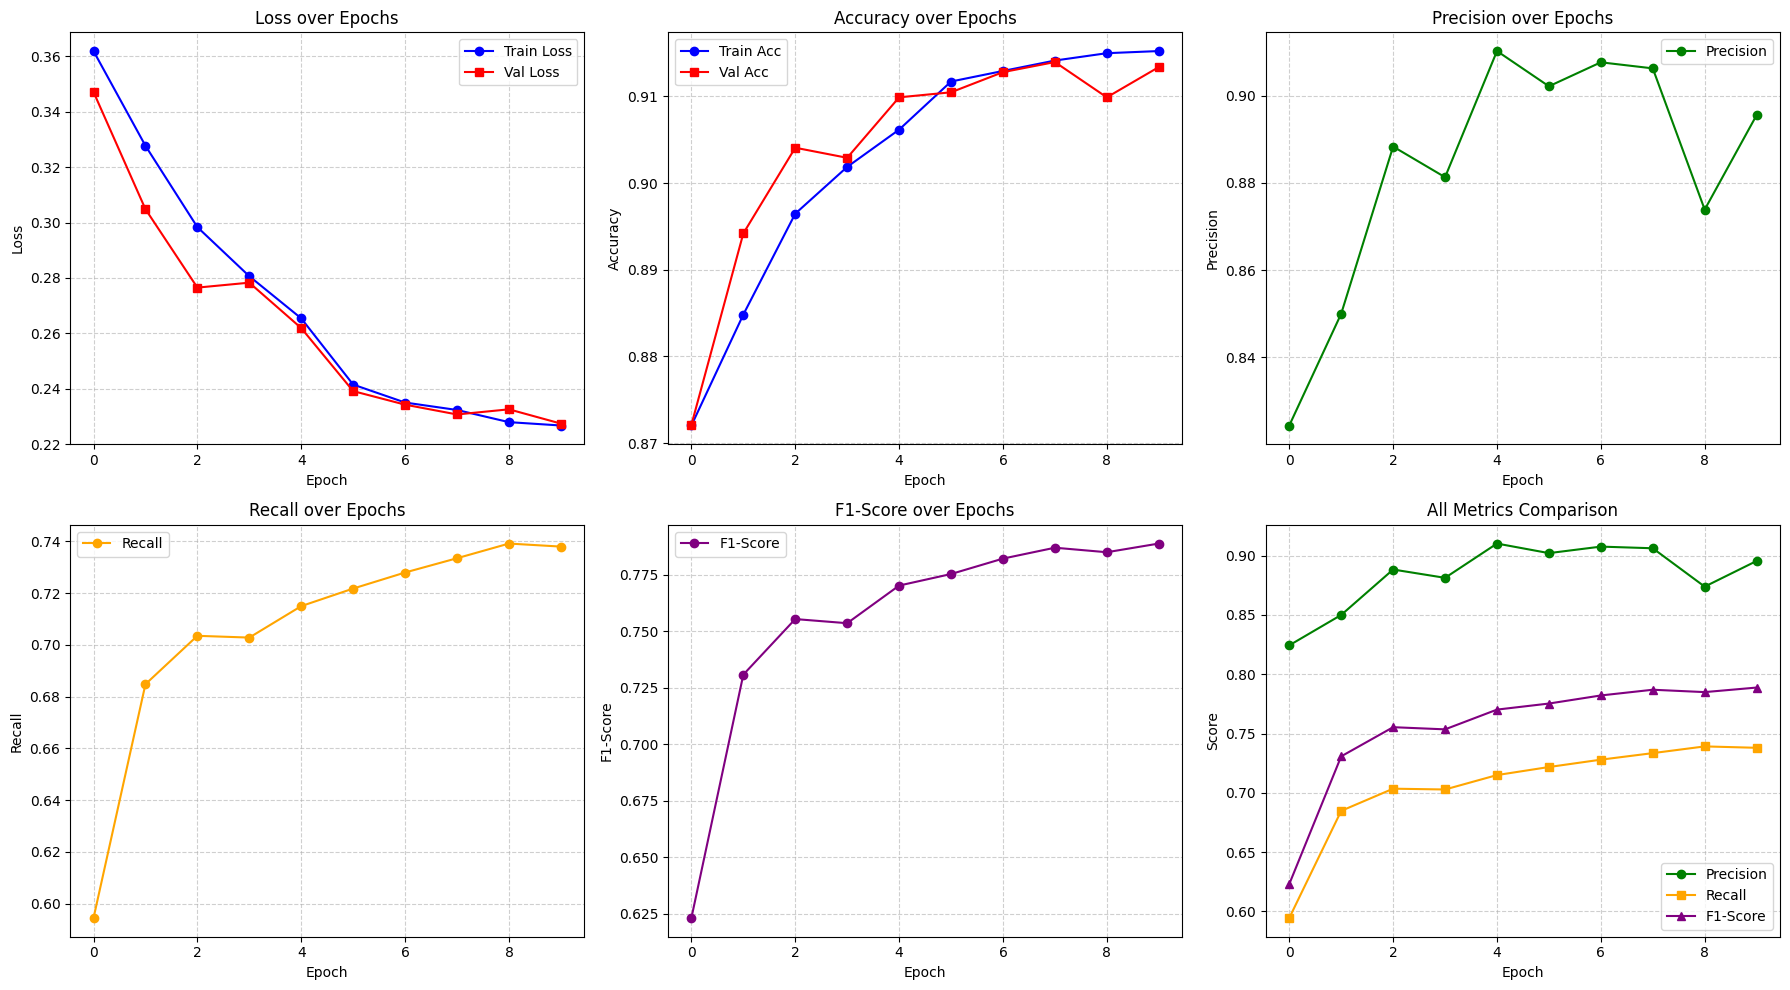

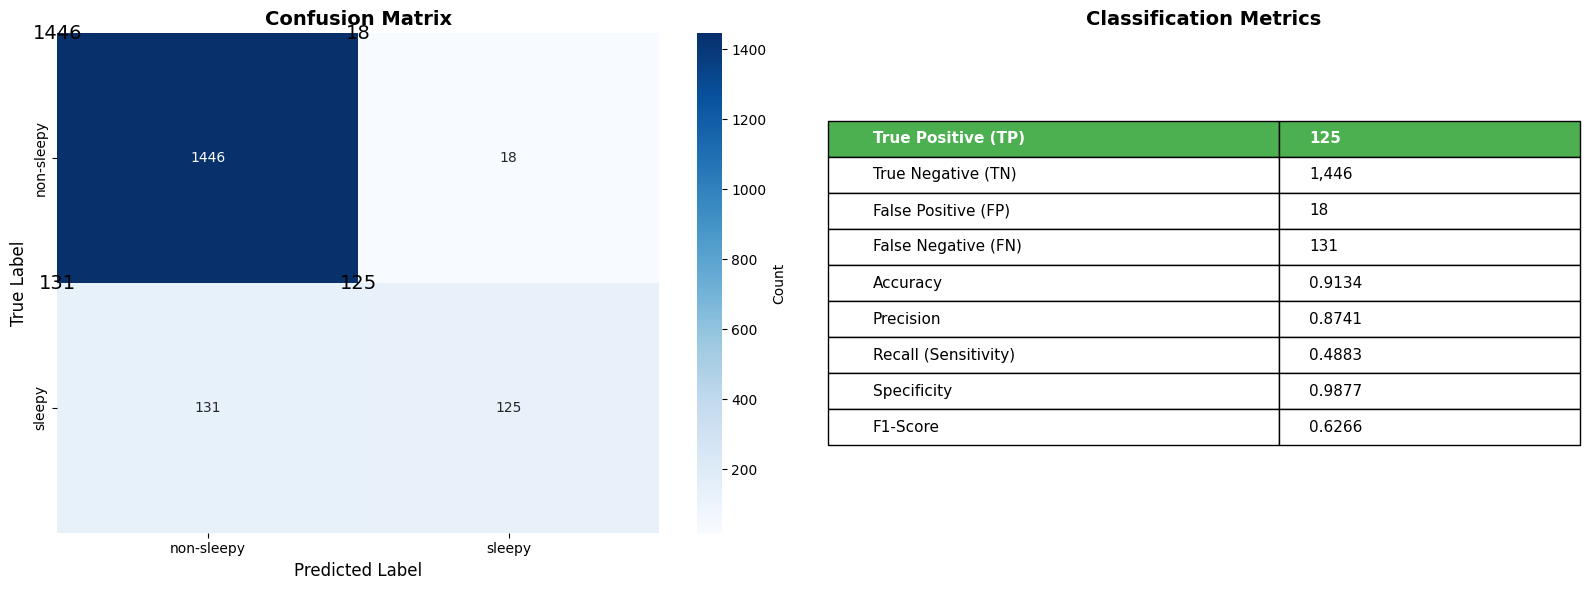

In [ ]:
# Train the model and get predictions for confusion matrix
trained_model, history, all_preds, all_labels = train_model(model, criterion, optimizer, scheduler)

# Plot all metrics including confusion matrix
plot_custom_metrics(history, all_labels, all_preds)